In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Num GPUs Available:  1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50,InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [3]:
train_dir = '/kaggle/input/mio-bd/MIO-BD/train'
test_dir = '/kaggle/input/mio-bd/MIO-BD/test'

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values between 0 and 1
    rotation_range=20,  # Randomly rotate images
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    horizontal_flip=True  # Randomly flip images horizontally
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize images to match DenseNet's input shape
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Keep the original order of the test data for evaluation
)

Found 14103 images belonging to 21 classes.
Found 3474 images belonging to 21 classes.


In [6]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : 0_Background
1 : 10_Leguna
2 : 11_Motorcycle
3 : 12_Multi-class Vehicles
4 : 13_Pedestrian
5 : 14_Pickuptruck
6 : 15_Rickshaw
7 : 16_Tractor
8 : 17_Truck
9 : 18_Van
10 : 19_Wheelbarrow
11 : 1_Bicycle
12 : 20_Workvan
13 : 2_Bike
14 : 3_Boat
15 : 4_Bus
16 : 5_Car
17 : 6_Cng
18 : 7_Easy-bike
19 : 8_Horse-cart
20 : 9_Launch


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, Model

from tensorflow.keras.layers import *

In [8]:
from tensorflow.keras.applications import MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, 
                         input_shape=(224, 224, 3))
x = base_model.output

x = Flatten()(x)

preds = tf.keras.layers.Dense(21, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=preds)

9406464/9406464 [==============================] - 1s 0us/step


In [9]:
for layer in model.layers:
    layer.trainable = True

In [10]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import regularizers
from keras import backend as K
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy', metrics=['accuracy','mse'])

checkpoint = ModelCheckpoint('BaseInceptionResNetv2_SplitedDataset.h5',
                             monitor='val_accuracy', save_best_only=True, save_best_weights=True, 
                             mode='max', verbose=2)

early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=15, mode='max', verbose=2)

reduce_learning_rate=ReduceLROnPlateau(monitor="val_accuracy",
                                       factor=0.1, patience=5, verbose=2)

In [11]:
history=model.fit(train_generator, epochs=50, validation_data=test_generator, 
                  callbacks= [checkpoint, early_stop, reduce_learning_rate])

Epoch 1/50
278/441 [=================>............] - ETA: 4:25 - loss: 3.0945 - accuracy: 0.3765 - mse: 0.0392

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


441/441 [==============================] - ETA: 0s - loss: 2.7753 - accuracy: 0.3999 - mse: 0.0375
Epoch 1: val_accuracy improved from -inf to 0.08866, saving model to BaseInceptionResNetv2_SplitedDataset.h5
441/441 [==============================] - 841s 2s/step - loss: 2.7753 - accuracy: 0.3999 - mse: 0.0375 - val_loss: 61.5047 - val_accuracy: 0.0887 - val_mse: 0.0849 - lr: 0.0010
Epoch 2/50
441/441 [==============================] - ETA: 0s - loss: 1.6460 - accuracy: 0.5395 - mse: 0.0296
Epoch 2: val_accuracy did not improve from 0.08866
441/441 [==============================] - 581s 1s/step - loss: 1.6460 - accuracy: 0.5395 - mse: 0.0296 - val_loss: 15.3487 - val_accuracy: 0.0815 - val_mse: 0.0706 - lr: 0.0010
Epoch 3/50
441/441 [==============================] - ETA: 0s - loss: 1.0439 - accuracy: 0.6498 - mse: 0.0225
Epoch 3: val_accuracy improved from 0.08866 to 0.11140, saving model to BaseInceptionResNetv2_SplitedDataset.h5
441/441 [==============================] - 605s 1s/st

In [12]:
test_result = model.evaluate(test_generator)
#                             steps=test_generator.samples // batch_size)
test_loss = test_result[0]
test_accuracy = test_result[1]
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

109/109 [==============================] - 62s 576ms/step - loss: 1.1679 - accuracy: 0.8092 - mse: 0.0151
Test Loss: 1.1678603887557983
Test Accuracy: 0.8091537356376648


In [13]:
from keras.models import load_model
model.save('BaseInceptionV3_SplitedDataset.h5')

import IPython
IPython.display.FileLink('BaseInceptionV3_SplitedDataset.h5')

/kaggle/working/BaseInceptionV3_SplitedDataset.h5

In [14]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

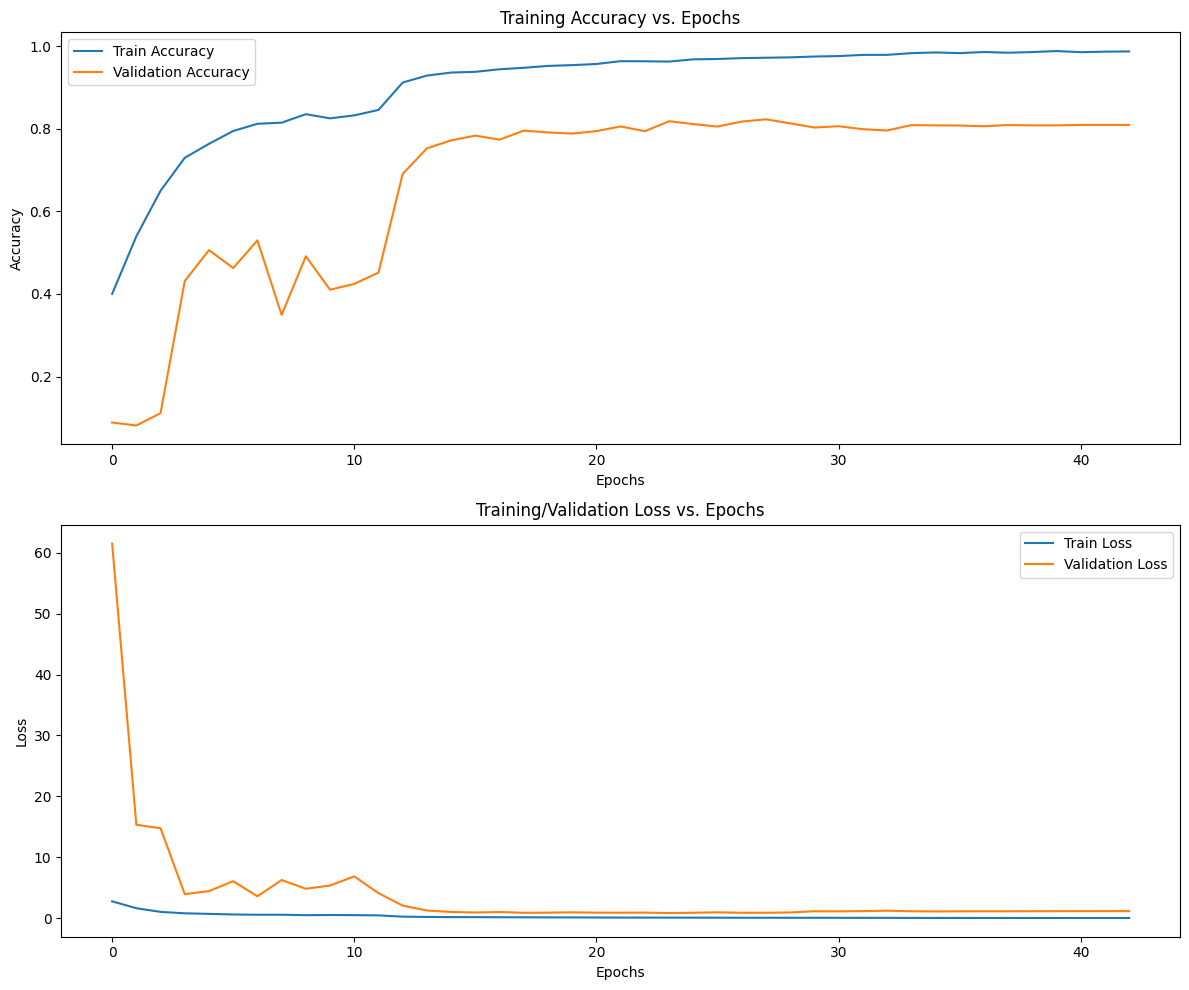

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy,label='Train Accuracy')
ax[0].plot(val_accuracy,label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss,label='Train Loss')
ax[1].plot(val_loss,label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

In [16]:
train_class_names = sorted(list(train_generator.class_indices.keys()))

test_class_names = sorted(list(test_generator.class_indices.keys()))

assert train_class_names == test_class_names, "Class names in train and test datasets don't match!"

labels = train_class_names

109/109 [==============================] - 63s 574ms/step


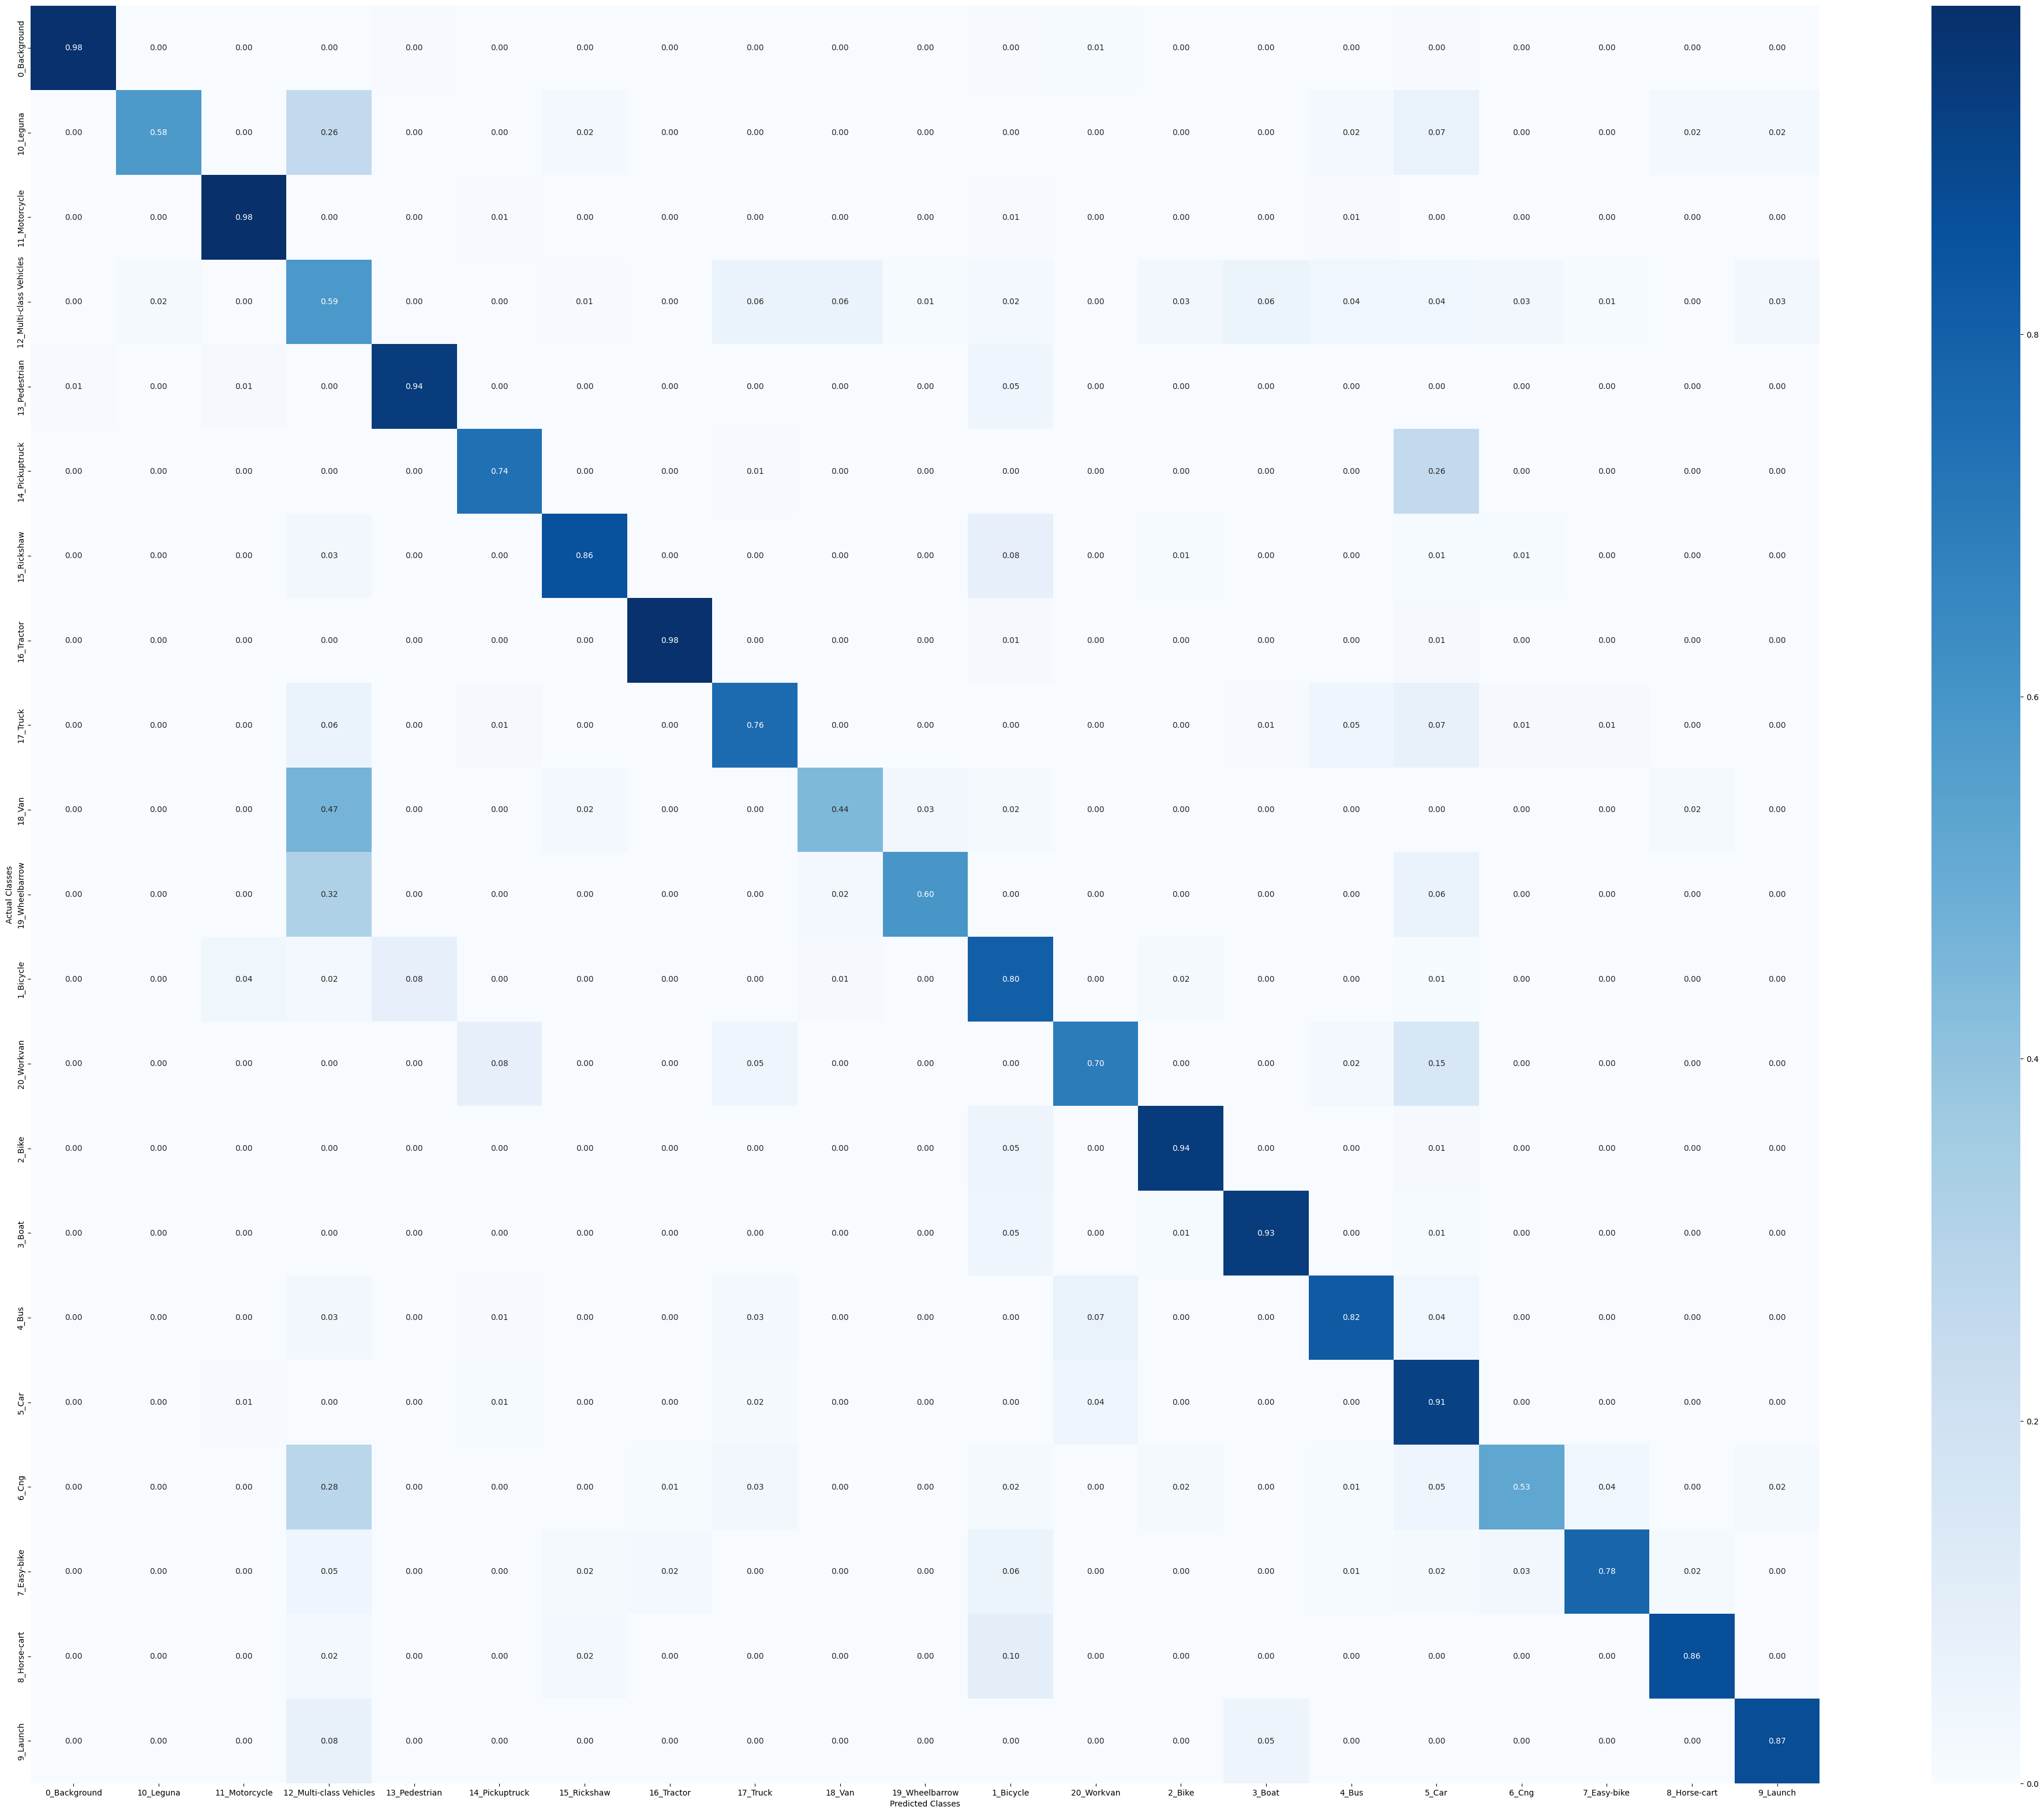

Confusion Matrix:
[[199   0   0   0   1   0   0   0   0   0   0   1   2   0   0   0   1   0
    0   0   0]
 [  0  25   0  11   0   0   1   0   0   0   0   0   0   0   0   1   3   0
    0   1   1]
 [  0   0 159   0   0   1   0   0   0   0   0   1   0   0   0   1   0   0
    0   0   0]
 [  0   3   0 109   0   0   1   0  12  12   2   4   0   6  11   7   7   5
    2   0   5]
 [  1   0   2   0 159   0   0   0   0   0   0   8   0   0   0   0   0   0
    0   0   0]
 [  0   0   0   0   0 118   0   0   1   0   0   0   0   0   0   0  41   0
    0   0   0]
 [  0   0   0   3   0   0  85   0   0   0   0   8   0   1   0   0   1   1
    0   0   0]
 [  0   0   0   0   0   0   0  84   0   0   0   1   0   0   0   0   1   0
    0   0   0]
 [  0   0   1  22   0   4   1   0 259   1   0   1   1   0   2  16  25   4
    5   0   0]
 [  0   0   0  57   0   0   3   0   0  54   4   2   0   0   0   0   0   0
    0   2   0]
 [  0   0   0  15   0   0   0   0   0   1  28   0   0   0   0   0   3   0
    0   0   0]
 [ 

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have the ground truth labels for the test data in a variable called 'true_labels'
true_labels = test_generator.classes

# Generate predictions for the test data
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Define class labels (replace with your actual class names)
labels = train_class_names  # Replace with your class names

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the heatmap
fig, ax = plt.subplots(figsize=(50, 40))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap=plt.cm.Blues)
plt.ylabel('Actual Classes')
plt.xlabel('Predicted Classes')

output_file = 'ConfusionMatrix_BaseResNet152V2_SplitedDataset.png'  
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

# Generate the classification report
report = classification_report(true_labels, predicted_labels)

print("Confusion Matrix:")
print(cm)


In [18]:
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       204
           1       0.89      0.58      0.70        43
           2       0.90      0.98      0.94       162
           3       0.39      0.59      0.47       186
           4       0.86      0.94      0.90       170
           5       0.81      0.74      0.77       160
           6       0.89      0.86      0.88        99
           7       0.95      0.98      0.97        86
           8       0.87      0.76      0.81       342
           9       0.75      0.44      0.56       122
          10       0.82      0.60      0.69        47
          11       0.80      0.80      0.80       287
          12       0.79      0.70      0.74       208
          13       0.91      0.94      0.93       172
          14       0.84      0.93      0.89       122
          15       0.87      0.82      0.85       268
          16       0.72      0.91      0.81       384
    